# Runtime Environment  
* python >= 3.6
* pytorch >= 1.0
* pandas
* nltk
* numpy
* sklearn
* pickle
* tqdm
* json

# Data processing

## 刪除多於資訊 (Remove redundant information)  
我們在資料集中保留了許多額外資訊供大家使用，但是在這次的教學中我們並沒有用到全部資訊，因此先將多餘的部分先抽走。  
In dataset, we reserved lots of information. But in this tutorial, we don't need them, so we need to discard them.

In [15]:
import pandas as pd

dataset = pd.read_csv('task1_trainset.csv', dtype=str)
dataset.head()

,Id,Title,Abstract,Authors,Categories,Created Date,Task 1
0,D00001,A Brain-Inspired Trust Management Model to Ass...,Rapid popularity of Internet of Things (IoT) a...,Mahmud/Kaiser/Rahman/Rahman/Shabut/Al-Mamun/Hu...,cs.CR/cs.AI/q-bio.NC,2018-01-11,BACKGROUND OBJECTIVES METHODS METHODS RESULTS ...
1,D00002,On Efficient Computation of Shortest Dubins Pa...,"In this paper, we address the problem of compu...",Sadeghi/Smith,cs.SY/cs.RO/math.OC,2016-09-21,OBJECTIVES OTHERS METHODS/RESULTS RESULTS RESULTS
2,D00003,Data-driven Upsampling of Point Clouds,High quality upsampling of sparse 3D point clo...,Zhang/Jiang/Yang/Yamakawa/Shimada/Kara,cs.CV,2018-07-07,BACKGROUND OBJECTIVES METHODS METHODS METHODS ...
3,D00004,Accessibility or Usability of InteractSE? A He...,Internet is the main source of information now...,Aqle/Khowaja/Al-Thani,cs.HC,2018-08-29,BACKGROUND BACKGROUND BACKGROUND OBJECTIVES OB...
4,D00005,Spatio-Temporal Facial Expression Recognition ...,Automated Facial Expression Recognition (FER) ...,Hasani/Mahoor,cs.CV,2017-03-20,BACKGROUND BACKGROUND BACKGROUND BACKGROUND ME...


In [16]:
dataset.drop('Title',axis=1,inplace=True)
dataset.drop('Categories',axis=1,inplace=True)
dataset.drop('Created Date',axis=1, inplace=True)
dataset.drop('Authors',axis=1,inplace=True)

## 資料切割  (Partition)
在訓練時，我們需要有個方法去檢驗訓練結果的好壞，因此需要將訓練資料切成training/validataion set。   
While training, we need some method to exam our model's performance, so we divide our training data into training/validataion set.

In [17]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
trainset, validset = train_test_split(dataset, test_size=0.1, random_state=42)

trainset.to_csv('trainset.csv',index=False)
validset.to_csv('validset.csv',index=False)

### For test data

In [19]:
dataset = pd.read_csv('task1_public_testset.csv', dtype=str)
dataset.drop('Title',axis=1,inplace=True)
dataset.drop('Categories',axis=1,inplace=True)
dataset.drop('Created Date',axis=1, inplace=True)
dataset.drop('Authors',axis=1,inplace=True)
dataset.to_csv('testset.csv',index=False)

In [20]:
dataset.shape

(20000, 2)

### 統計單字 (Count words)  
在訓練時，不能直接將單字直接餵入model，因為它只看得懂數字，因此我們必須把所有的單字抽取出來，並將它們打上編號，做出一個字典來對它們做轉換。
We can't feed "word" into model directly, since it can only recognize number. So, we need to know the total number of word, and give every word a unique number.  

在這裡，我們需要借助`nltk`這個library來幫忙做文字切割。當然，你也可以選擇自己寫規則來切割(通常上不建議搞死自己)。  
另外，我們也使用了`multiprocessing`來加速處理。  
In here, we split words by using `nltk library`. You can write your own rules and split it by yourself, but you won't want to do that, trust me.  
Also, we use `multiprocessing` to accelerate the process.

In [21]:
import pandas as pd
from multiprocessing import Pool
from nltk.tokenize import word_tokenize
def collect_words(data_path, n_workers=4):
    df = pd.read_csv(data_path, dtype=str)
        
    sent_list = []
    for i in df.iterrows():
        sent_list += i[1]['Abstract'].split('$$$')

    chunks = [
        ' '.join(sent_list[i:i + len(sent_list) // n_workers])
        for i in range(0, len(sent_list), len(sent_list) // n_workers)
    ]
    with Pool(n_workers) as pool:
        chunks = pool.map_async(word_tokenize, chunks)
        words = set(sum(chunks.get(), []))

    return words

In [22]:
words = set()
words |= collect_words('trainset.csv')

pad: for padding  
unk: for word that didn't in our dicitonary

In [23]:
PAD_TOKEN = 0
UNK_TOKEN = 1
word_dict = {'<pad>':PAD_TOKEN,'<unk>':UNK_TOKEN}
for word in words:
    word_dict[word]=len(word_dict)

In [24]:
import pickle
with open('dicitonary.pkl','wb') as f:
    pickle.dump(word_dict, f)

### 資料格式化 (Data formatting)  
有了字典後，接下來我們要把資料整理成一筆一筆，把input的句子轉成數字，把答案轉成onehot的形式。  
這裡，我們一樣使用`multiprocessing`來加入進行。  
After building dictionary, that's mapping our sentences into number array, and convert answers to onehot format.  

In [25]:
from tqdm import tqdm_notebook as tqdm
def label_to_onehot(labels):
    """ Convert label to onehot .
        Args:
            labels (string): sentence's labels.
        Return:
            outputs (onehot list): sentence's onehot label.
    """
    label_dict = {'BACKGROUND': 0, 'OBJECTIVES':1, 'METHODS':2, 'RESULTS':3, 'CONCLUSIONS':4, 'OTHERS':5}
    onehot = [0,0,0,0,0,0]
    for l in labels.split('/'):
        onehot[label_dict[l]] = 1
    return onehot
        
def sentence_to_indices(sentence, word_dict):
    """ Convert sentence to its word indices.
    Args:
        sentence (str): One string.
    Return:
        indices (list of int): List of word indices.
    """
    return [word_dict.get(word,UNK_TOKEN) for word in word_tokenize(sentence)]
    
def get_dataset(data_path, word_dict, n_workers=4):
    """ Load data and return dataset for training and validating.

    Args:
        data_path (str): Path to the data.
    """
    dataset = pd.read_csv(data_path, dtype=str)

    results = [None] * n_workers
    with Pool(processes=n_workers) as pool:
        for i in range(n_workers):
            batch_start = (len(dataset) // n_workers) * i
            if i == n_workers - 1:
                batch_end = len(dataset)
            else:
                batch_end = (len(dataset) // n_workers) * (i + 1)
            
            batch = dataset[batch_start: batch_end]
            results[i] = pool.apply_async(preprocess_samples, args=(batch,word_dict))

        pool.close()
        pool.join()

    processed = []
    for result in results:
        processed += result.get()
    return processed

def preprocess_samples(dataset, word_dict):
    """ Worker function.

    Args:
        dataset (list of dict)
    Returns:
        list of processed dict.
    """
    processed = []
    for sample in tqdm(dataset.iterrows(), total=len(dataset)):
        processed.append(preprocess_sample(sample[1], word_dict))

    return processed

def preprocess_sample(data, word_dict):
    """
    Args:
        data (dict)
    Returns:
        dict
    """
    processed = {}
    processed['Abstract'] = [sentence_to_indices(sent, word_dict) for sent in data['Abstract'].split('$$$')]
    if 'Task 1' in data:
        processed['Label'] = [label_to_onehot(label) for label in data['Task 1'].split(' ')]
        
    return processed

In [26]:
print('[INFO] Start processing trainset...')
train = get_dataset('trainset.csv', word_dict, n_workers=4)
print('[INFO] Start processing validset...')
valid = get_dataset('validset.csv', word_dict, n_workers=4)
print('[INFO] Start processing testset...')
test = get_dataset('testset.csv', word_dict, n_workers=4)

[INFO] Start processing trainset...




[INFO] Start processing validset...




[INFO] Start processing testset...






## 資料封裝 (Data packing)

為了更方便的進行batch training，我們將會借助[torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)。  
而要將資料放入dataloader，我們需要繼承[torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)，撰寫適合這份dataset的class。  
`collate_fn`用於batch data的後處理，在`dataloder`將選出的data放進list後會呼叫collate_fn，而我們會在此把sentence padding到同樣的長度，才能夠放入torch tensor (tensor必須為矩陣)。  

To easily training in batch, we'll use `dataloader`, which is a function built in Pytorch[torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)  
To use datalaoder, we need to packing our data into class `dataset` [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)  
`collate_fn` is used for data processing.

In [27]:
from torch.utils.data import Dataset
import torch
class AbstractDataset(Dataset):
    def __init__(self, data, pad_idx, max_len = 500):
        self.data = data
        self.pad_idx = pad_idx
        self.max_len = max_len
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]
        
    def collate_fn(self, datas):
        # get max length in this batch
        max_sent = max([len(data['Abstract']) for data in datas])
        max_len = max([min(len(sentence), self.max_len) for data in datas for sentence in data['Abstract']])
        batch_abstract = []
        batch_label = []
        sent_len = []
        for data in datas:
            # padding abstract to make them in same length
            pad_abstract = []
            for sentence in data['Abstract']:
                if len(sentence) > max_len:
                    pad_abstract.append(sentence[:max_len])
                else:
                    pad_abstract.append(sentence+[self.pad_idx]*(max_len-len(sentence)))
            sent_len.append(len(pad_abstract))
            pad_abstract.extend([[self.pad_idx]*max_len]*(max_sent-len(pad_abstract)))
            batch_abstract.append(pad_abstract)
            # gather labels
            if 'Label' in data:
                pad_label = data['Label']
                pad_label.extend([[0]*6]*(max_sent-len(pad_label)))
                
                batch_label.append(pad_label)
        return torch.LongTensor(batch_abstract), torch.FloatTensor(batch_label), sent_len

In [28]:
trainData = AbstractDataset(train, PAD_TOKEN, max_len = 64)
validData = AbstractDataset(valid, PAD_TOKEN, max_len = 64)
testData = AbstractDataset(test, PAD_TOKEN, max_len = 64)

# Model

資料處理完成後，接下來就是最重要的核心部分：`Model`。  
此次範例中我們以簡單的一層RNN + 兩層Linear layer作為示範。  
而為了解決每次的句子長度不一的問題(`linear layer必須是fixed input size`)，因此我們把所有字的hidden_state做平均，讓這一個vector代表這句話。  

In this tutorial, we're going to implement a simple model, which contain one RNN layer and two fully connected layers (Linear layer). Of course you can make it "deep".  
To solve variant sentence length problem (`input size in linear layer must be fixed`), we can average all hidden_states, and become one vector. (Perfect!)

In [29]:
import torch.nn as nn
import torch.nn.functional as F


class simpleNet(nn.Module):
    def __init__(self, vocabulary_size):
        super(simpleNet, self).__init__()
        self.embedding_size = 50
        self.hidden_dim = 512
        self.embedding = nn.Embedding(vocabulary_size, self.embedding_size)
        self.sent_rnn = nn.GRU(self.embedding_size,
                                self.hidden_dim,
                                bidirectional=True,
                                batch_first=True)
        self.l1 = nn.Linear(self.hidden_dim*2, self.hidden_dim)
        self.l2 = nn.Linear(self.hidden_dim, 6)

    def forward(self, x):
        x = self.embedding(x)
        b,s,w,e = x.shape
        x = x.view(b,s*w,e)
        x, __ = self.sent_rnn(x)
        x = x.view(b,s,w,-1)
        x = torch.max(x,dim=2)[0]
        x = torch.relu(self.l1(x))
        x = torch.sigmoid(self.l2(x))
        return x

# Training

指定使用的運算裝置  
Designate running device.

In [30]:
device='cuda'
torch.cuda.set_device(2)

定義一個算分公式, 讓我們在training能快速了解model的效能  
Define score function, let us easily observe model performance while training.  

In [31]:
class F1():
    def __init__(self):
        self.threshold = 0.5
        self.n_precision = 0
        self.n_recall = 0
        self.n_corrects = 0
        self.name = 'F1'

    def reset(self):
        self.n_precision = 0
        self.n_recall = 0
        self.n_corrects = 0

    def update(self, predicts, groundTruth):
        predicts = predicts > self.threshold
        self.n_precision += torch.sum(predicts).data.item()
        self.n_recall += torch.sum(groundTruth).data.item()
        self.n_corrects += torch.sum(groundTruth.type(torch.uint8) * predicts).data.item()

    def get_score(self):
        recall = self.n_corrects / self.n_recall
        precision = self.n_corrects / (self.n_precision + 1e-20) #prevent divided by zero
        return 2 * (recall * precision) / (recall + precision + 1e-20)

    def print_score(self):
        score = self.get_score()
        return '{:.5f}'.format(score)


In [32]:
import os
def _run_epoch(epoch, training):
    model.train(training)
    if training:
        description = 'Train'
        dataset = trainData
        shuffle = True
    else:
        description = 'Valid'
        dataset = validData
        shuffle = False
    dataloader = DataLoader(dataset=dataset,
                            batch_size=64,
                            shuffle=shuffle,
                            collate_fn=dataset.collate_fn,
                            num_workers=4)

    trange = tqdm(enumerate(dataloader), total=len(dataloader), desc=description)
    loss = 0
    f1_score = F1()
    for i, (x, y, sent_len) in trange:
        o_labels, batch_loss = _run_iter(x,y)
        if training:
            opt.zero_grad()
            batch_loss.backward()
            opt.step()

        loss += batch_loss.item()
        f1_score.update(o_labels.cpu(), y)

        trange.set_postfix(
            loss=loss / (i + 1), f1=f1_score.print_score())
    if training:
        history['train'].append({'f1':f1_score.get_score(), 'loss':loss/ len(trange)})
    else:
        history['valid'].append({'f1':f1_score.get_score(), 'loss':loss/ len(trange)})

def _run_iter(x,y):
    abstract = x.to(device)
    labels = y.to(device)
    o_labels = model(abstract)
    l_loss = criteria(o_labels, labels)
    return o_labels, l_loss

def save(epoch):
    if not os.path.exists('model'):
        os.makedirs('model')
    torch.save(model.state_dict(), 'model/model.pkl.'+str(epoch))
    with open('model/history.json', 'w') as f:
        json.dump(history, f, indent=4)

In [33]:
from torch.utils.data import DataLoader
from tqdm import trange
import json
model = simpleNet(len(word_dict))
opt = torch.optim.Adam(model.parameters())
criteria = torch.nn.BCELoss()
model.to(device)
max_epoch = 6
history = {'train':[],'valid':[]}

for epoch in range(max_epoch):
    print('Epoch: {}'.format(epoch))
    _run_epoch(epoch, True)
    _run_epoch(epoch, False)
    save(epoch)

Epoch: 0



Epoch: 1



Epoch: 2



Epoch: 3



Epoch: 4



Epoch: 5


## Predict

In [34]:
model.train(False)
dataloader = DataLoader(dataset=testData,
                            batch_size=64,
                            shuffle=False,
                            collate_fn=testData.collate_fn,
                            num_workers=4)
trange = tqdm(enumerate(dataloader), total=len(dataloader), desc='Predict')
prediction = []
for i, (x, y, sent_len) in trange:
    o_labels = model(x.to(device))
    o_labels = o_labels>0.5
    for idx, o_label in enumerate(o_labels):
        prediction.append(o_label[:sent_len[idx]].to('cpu'))
prediction = torch.cat(prediction).detach().numpy().astype(int)

In [37]:
prediction.shape

(131166, 6)

In [39]:
import numpy as np
def SubmitGenerator(prediction, sampleFile, public=True, filename='prediction.csv'):
    sample = pd.read_csv(sampleFile)
    submit = {}
    submit['order_id'] = list(sample.order_id.values)
    redundant = len(sample) - prediction.shape[0]
    if public:
        submit['BACKGROUND'] = list(prediction[:,0]) + [0]*redundant
        submit['OBJECTIVES'] = list(prediction[:,1]) + [0]*redundant
        submit['METHODS'] = list(prediction[:,2]) + [0]*redundant
        submit['RESULTS'] = list(prediction[:,3]) + [0]*redundant
        submit['CONCLUSIONS'] = list(prediction[:,4]) + [0]*redundant
        submit['OTHERS'] = list(prediction[:,5]) + [0]*redundant
    else:
        submit['BACKGROUND'] = [0]*redundant + list(prediction[:,0])
        submit['OBJECTIVES'] = [0]*redundant + list(prediction[:,1])
        submit['METHODS'] = [0]*redundant + list(prediction[:,2])
        submit['RESULTS'] = [0]*redundant + list(prediction[:,3])
        submit['CONCLUSIONS'] = [0]*redundant + list(prediction[:,4])
        submit['OTHERS'] = [0]*redundant + list(prediction[:,5])
    df = pd.DataFrame.from_dict(submit) 
    print(df.shape)
    df.to_csv(filename,index=False)

In [40]:
SubmitGenerator(prediction,
                'task1_sample_submission.csv', 
                True, 
                'task1_submission.csv')

(262948, 7)


# Plot Learning Curve

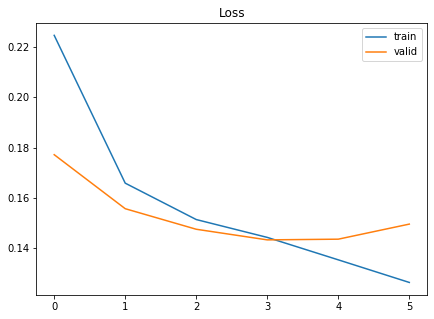

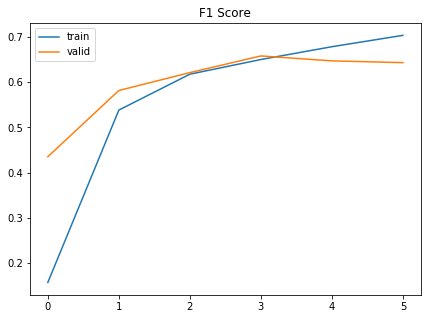

Best F1 score  [0.6579126544110494, 3]


In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

with open('model/history.json', 'r') as f:
    history = json.loads(f.read())
    
train_loss = [l['loss'] for l in history['train']]
valid_loss = [l['loss'] for l in history['valid']]
train_f1 = [l['f1'] for l in history['train']]
valid_f1 = [l['f1'] for l in history['valid']]

plt.figure(figsize=(7,5))
plt.title('Loss')
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.title('F1 Score')
plt.plot(train_f1, label='train')
plt.plot(valid_f1, label='valid')
plt.legend()
plt.show()

print('Best F1 score ', max([[l['f1'], idx] for idx, l in enumerate(history['valid'])]))